In [3]:
import os
import glob
import json
from numpy import genfromtxt
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [24]:
def plot_curves(files, title, labeler):
    alldata = []
    
    plt.figure(figsize=(15, 10))
    plt.title(title)
    
    for f in files:
        job_id = int(f.split("/")[1])
        jobdir = "/".join(f.split("/")[:-1]) + "/"
    
        with open(jobdir + "command.txt", "r") as f:
            com = f.readlines()
            
        args = json.load(open(jobdir + "args.txt", "r"))
        
        label = labeler(job_id, com, args)
        
        if label is None:
            continue
        
        data = genfromtxt(jobdir + 'scores.txt', delimiter='\t', skip_header=1)
        steps = data[:, 1]
        means = data[:, 3]

        #plt.plot(data[:, 0], data[:, 3])
        alldata.append([label, job_id, steps, means])
        
    types = list(set([d[0] for d in alldata]))
    
    for t in types:
        allmeans = []
        
        for label, job, steps, means in alldata:
            if label == t:
                allmeans.append(means)
                s = steps
        
        minlen = min([len(m) for m in allmeans])
        allmeans = [m[:minlen] for m in allmeans]
        
        allmeans = np.array(allmeans)
        
        means = np.mean(allmeans, axis=0)
        stds = np.std(allmeans, axis=0)
        
        t += " {" + str(len(allmeans)) + "}"
        
        p = plt.plot(s[:minlen], means, label=t)
        
        for mean in allmeans:
            plt.plot(s[:minlen], mean, color=p[0].get_color() + "30")
        #plt.fill_between(s[:minlen], means-stds, means+stds, color=p[0].get_color() + "20")
    
    plt.plot([0, 1000000], [-110, -110], lw=2, ls="--")
    plt.xlim((0, 10000))
    plt.legend()
    plt.show()

In [25]:
def labeler(job, com, args):
    if job < 125407:
        return None
    
    com = com[0]
    label = ""
    
    #print(com)
    
    if 'train_dqn_gym' in com:
        label += "DQN"
    elif 'train_categorical' in com:
        label += "C51"
        return None
        
    if args['noisy_net_sigma'] and args['noise_constant'] > 0:
        label += " constant noise (sigma = " + str(args['noise_constant']) + ")"
    elif args['noisy_net_sigma']:
        label += " noisy nets (sigma0 = " + str(args['noisy_net_sigma']) + ")"
    
    return label

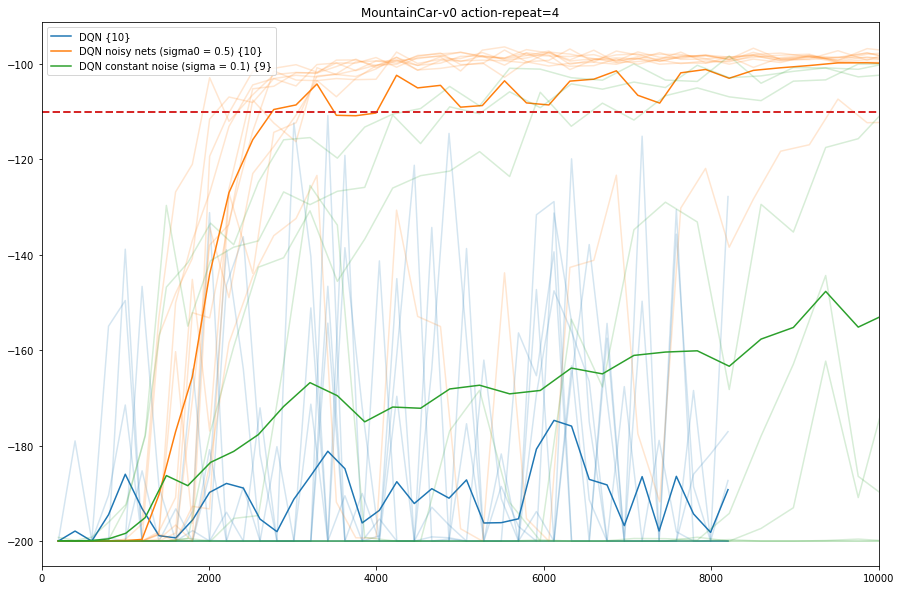

In [26]:
plot_curves(glob.glob("results/*/*/scores.txt"), "MountainCar-v0 action-repeat=4", labeler)